# 📊 Customer Churn Prediction Project
This notebook covers:
- Data loading
- Preprocessing
- Exploratory Data Analysis
- Model training and evaluation
- Model saving using `joblib`


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

sns.set(style='whitegrid')

## 1️⃣ Load Dataset

In [47]:
# Update the path as needed for your environment
data = pd.read_csv('Telco-Customer-Churn_dataset.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2️⃣ Data Cleaning & Preprocessing

In [48]:
# Drop 'customerID' as it is not useful for prediction
data.drop('customerID', axis=1, inplace=True)

# Convert 'TotalCharges' to numeric and handle missing
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.dropna(inplace=True)

# Label encoding categorical columns
cat_cols = data.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    data[col] = le.fit_transform(data[col])

data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


## 3️⃣ Exploratory Data Analysis (EDA)

In [49]:
# Describe data
data.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.504693,0.162400,0.482509,0.298493,32.421786,0.903299,0.940557,0.872582,0.789249,0.905859,0.903868,0.796359,0.984926,0.992890,0.688567,0.592719,1.573237,64.798208,2283.300441,0.265785
std,0.500014,0.368844,0.499729,0.457629,24.545260,0.295571,0.948627,0.737271,0.859962,0.880394,0.880178,0.861674,0.885285,0.885385,0.832934,0.491363,1.067504,30.085974,2266.771362,0.441782
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.587500,401.450000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.350000,1397.475000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.862500,3794.737500,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000,1.000000


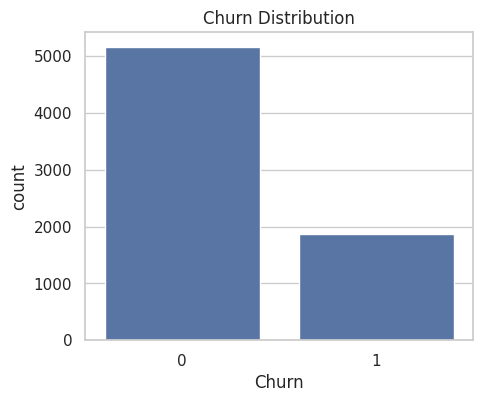

In [50]:
# Churn distribution
plt.figure(figsize=(5, 4))
sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.show()

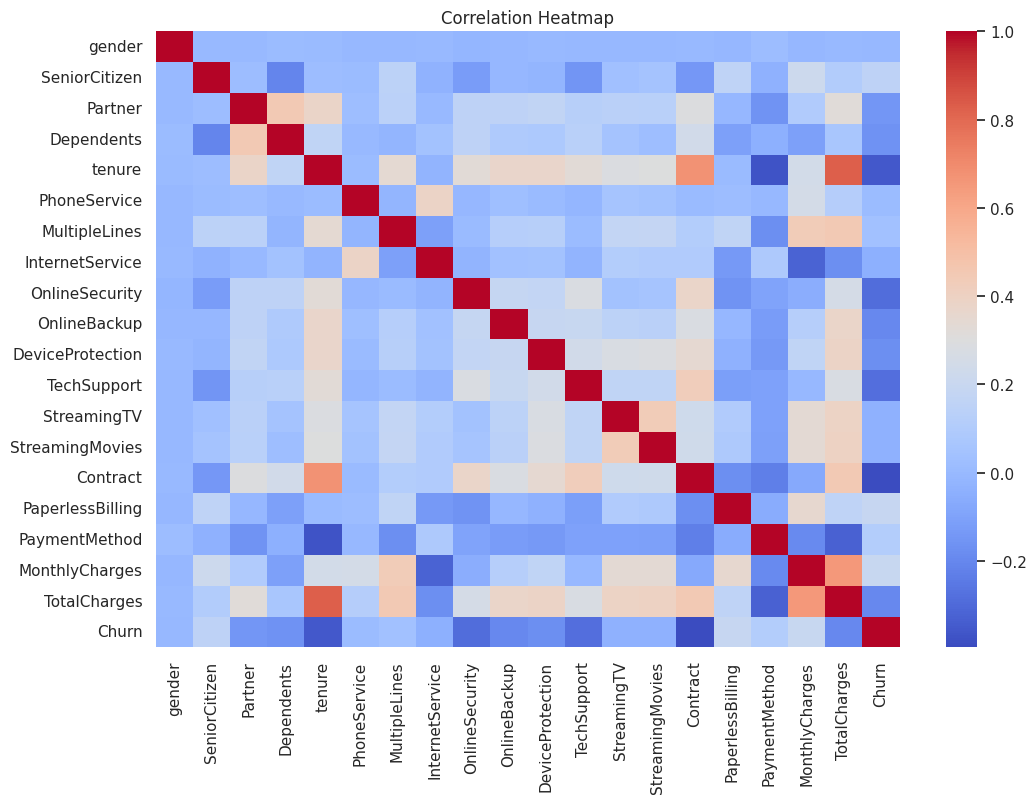

In [51]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

## 4️⃣ Feature and Target Split

In [52]:
X = data.drop('Churn', axis=1)
y = data['Churn']

## 5️⃣ Train-Test Split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6️⃣ Model Building - Random Forest

In [54]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

## 7️⃣ Model Evaluation

In [55]:
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407

Accuracy: 0.783226723525231
ROC-AUC Score: 0.8113316698676303


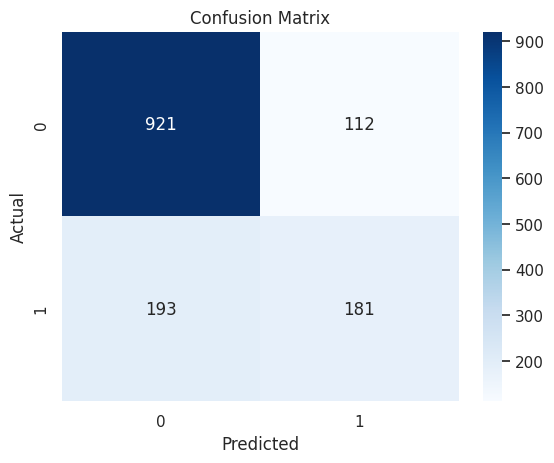

In [56]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

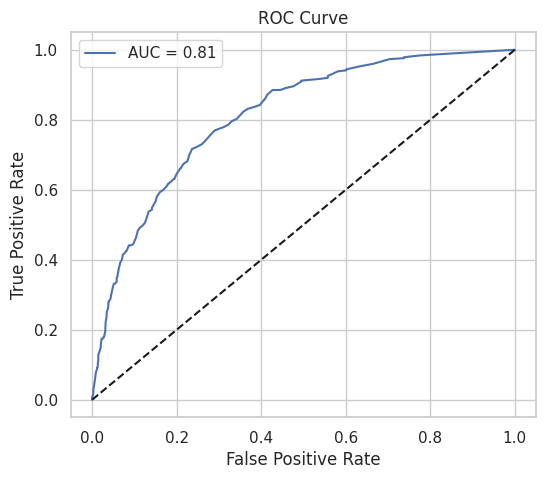

In [57]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_prob):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 8️⃣ Feature Importance

/tmp/ipython-input-58-1971276378.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette='viridis')


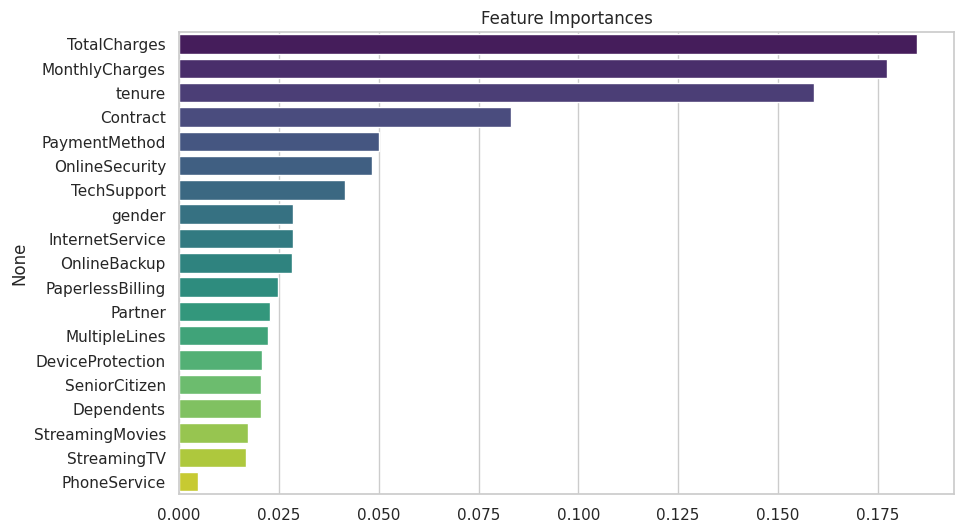

In [58]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
plt.title('Feature Importances')
plt.show()

## 9️⃣ Save the Trained Model

In [59]:
with open('customer_churn_model.pkl', 'wb') as file:
    pickle.dump(model, file)

✅ **Your customer churn prediction pipeline is now cleanly structured in this notebook for training, evaluation, and future model use.**